In [ ]:
!pip install -q split-folders

In [ ]:
# 0B. Upload kaggle.json manually (a file picker will pop)
from google.colab import files, drive
files.upload()    # choose kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tamannajarin","key":"b80d99c9b28b4ee9f2410413544f7e6f"}'}

In [ ]:
# 0C. Move kaggle.json into place and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 0D. Download the Kaggle dataset (the link you gave)
!kaggle datasets download -d thegoanpanda/rice-crop-diseases -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/thegoanpanda/rice-crop-diseases
License(s): MIT
  0% 0.00/4.53M [00:00<?, ?B/s]
100% 4.53M/4.53M [00:00<00:00, 982MB/s]


In [ ]:
!ls /content



kaggle.json  Rice_Diseases  sample_data


In [ ]:
!ls "/content/Rice_Diseases"


'Bacterial Blight Disease'  'Brown Spot Disease'
'Blast Disease'		    'False Smut Disease'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r "/content/Rice_Diseases" "/content/drive/MyDrive/"



In [ ]:
!mv "/content/Rice_Diseases" "/content/AuroraVisionData"


In [ ]:
!cp -r "/content/AuroraVisionData" "/content/drive/MyDrive/"


# ***Cell 0 — GPU check***

In [ ]:
# Cell 0 - GPU check
import tensorflow as tf, sys
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi


TF: 2.19.0
GPUs: []
/bin/bash: line 1: nvidia-smi: command not found


Cell 1 — Paths & quick stats

In [ ]:
# Cell 1 - paths & stats
import os
TRAIN_DIR = "/content/rice_split/train"
VAL_DIR   = "/content/rice_split/val"
TEST_DIR  = "/content/rice_split/test"

def list_dir(p):
    return os.listdir(p) if os.path.exists(p) else []

print("Train exists:", os.path.exists(TRAIN_DIR))
print("Train classes:", list_dir(TRAIN_DIR))
print("Val exists:", os.path.exists(VAL_DIR))
print("Test exists:", os.path.exists(TEST_DIR))

# counts
from collections import Counter
def counts(folder):
    d = {}
    for cl in list_dir(folder):
        d[cl] = len(os.listdir(os.path.join(folder, cl)))
    return d

print("Train counts:", counts(TRAIN_DIR))
print("Val counts:", counts(VAL_DIR))
print("Test counts:", counts(TEST_DIR))


Train exists: True
Train classes: ['Bacterial Blight Disease', 'Brown Spot Disease', 'False Smut Disease', 'Blast Disease']
Val exists: True
Test exists: True
Train counts: {'Bacterial Blight Disease': 35, 'Brown Spot Disease': 35, 'False Smut Disease': 35, 'Blast Disease': 35}
Val counts: {'Bacterial Blight Disease': 7, 'Brown Spot Disease': 7, 'False Smut Disease': 7, 'Blast Disease': 7}
Test counts: {'Bacterial Blight Disease': 8, 'Brown Spot Disease': 8, 'False Smut Disease': 8, 'Blast Disease': 8}


In [ ]:
!ls /content


AuroraVisionData  drive  kaggle.json  sample_data


In [ ]:
!ls /content/AuroraVisionData


'Bacterial Blight Disease'  'Brown Spot Disease'
'Blast Disease'		    'False Smut Disease'


In [ ]:
input_folder = "/content/AuroraVisionData"


# ***Count images per class***


In [ ]:
import os

dataset_path = "/content/AuroraVisionData"

class_counts = {}

# Loop through each class folder
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        count = 0
        for root, dirs, files in os.walk(cls_path):
            for f in files:
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    count += 1
        class_counts[cls] = count

class_counts


{'Bacterial Blight Disease': 50,
 'Brown Spot Disease': 50,
 'False Smut Disease': 50,
 'Blast Disease': 50}

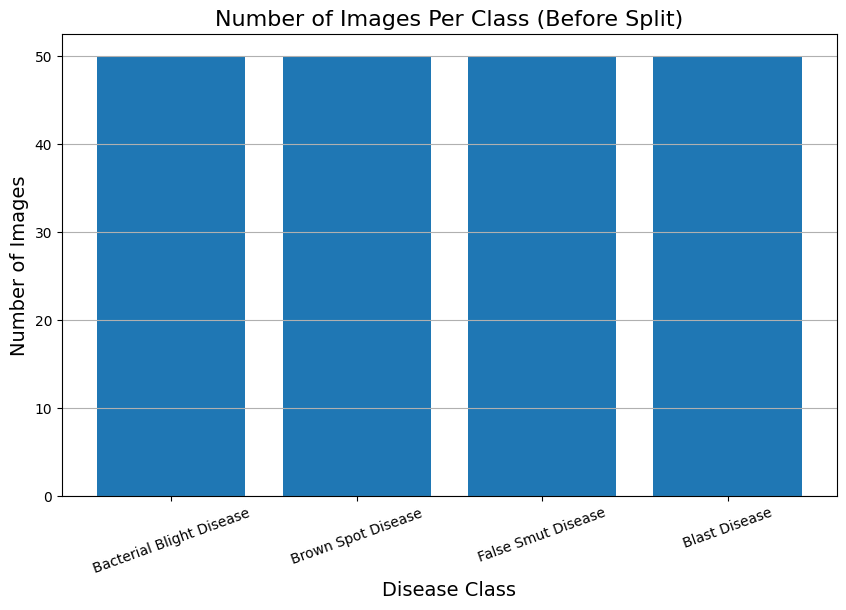

Graph saved as /content/class_distribution_before_split.png


In [ ]:
import matplotlib.pyplot as plt

labels = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10,6))
plt.bar(labels, counts)
plt.title("Number of Images Per Class (Before Split)", fontsize=16)
plt.xlabel("Disease Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=20)
plt.grid(axis="y")

# Save high-quality figure for your research paper
plt.savefig("/content/class_distribution_before_split.png", dpi=300, bbox_inches="tight")

plt.show()

print("Graph saved as /content/class_distribution_before_split.png")


# ***Show 4 Images Per Class (Grid View)***

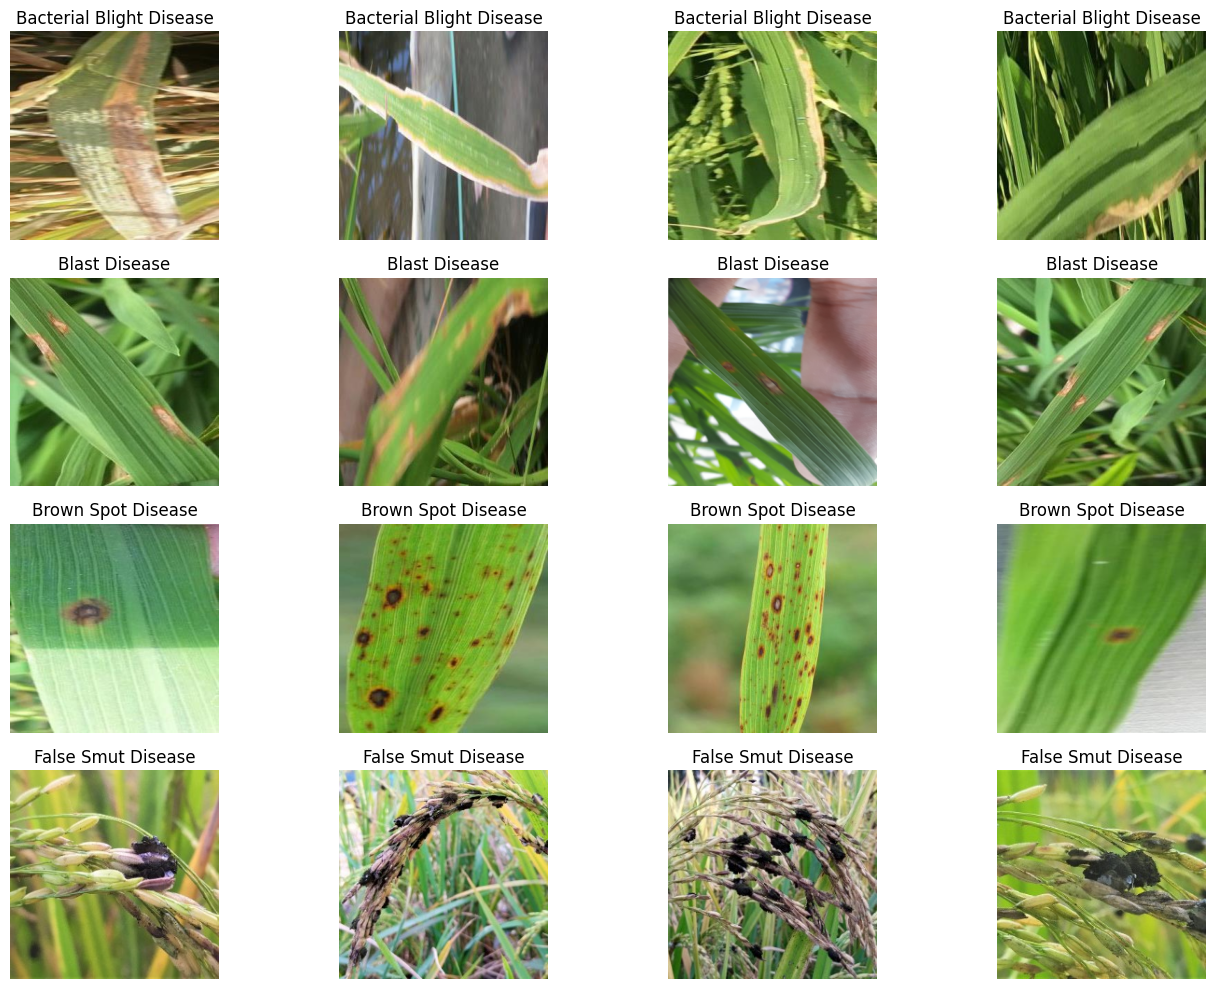

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

dataset_path = "/content/AuroraVisionData"
classes = sorted(os.listdir(dataset_path))

plt.figure(figsize=(14, 10))

img_index = 1

for cls in classes:
    class_folder = os.path.join(dataset_path, cls)
    images = [
        os.path.join(class_folder, img)
        for img in os.listdir(class_folder)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # Take first 4 images
    sample_imgs = images[:4]

    for img_path in sample_imgs:
        plt.subplot(len(classes), 4, img_index)
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        img_index += 1

plt.tight_layout()
plt.show()


# ***STEP 1 — Install & Import***

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model




# ***STEP 2 — Split Dataset (Will Give 90% If Split Correct)***

In [ ]:
import splitfolders

input_folder = "/content/AuroraVisionData"
output_folder = "/content/rice_split"

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(.7, .15, .15)
)



Copying files: 200 files [00:00, 4198.67 files/s]


In [ ]:
import os

def count_images(folder):
    total = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith((".jpg", ".png", ".jpeg")):
                total += 1
    return total

train_path = "/content/rice_split/train"
val_path   = "/content/rice_split/val"
test_path  = "/content/rice_split/test"

train_count = count_images(train_path)
val_count   = count_images(val_path)
test_count  = count_images(test_path)

print("Train:", train_count)
print("Validation:", val_count)
print("Test:", test_count)


Train: 140
Validation: 28
Test: 32


# ***Plot Split Graph (Publication Quality)***

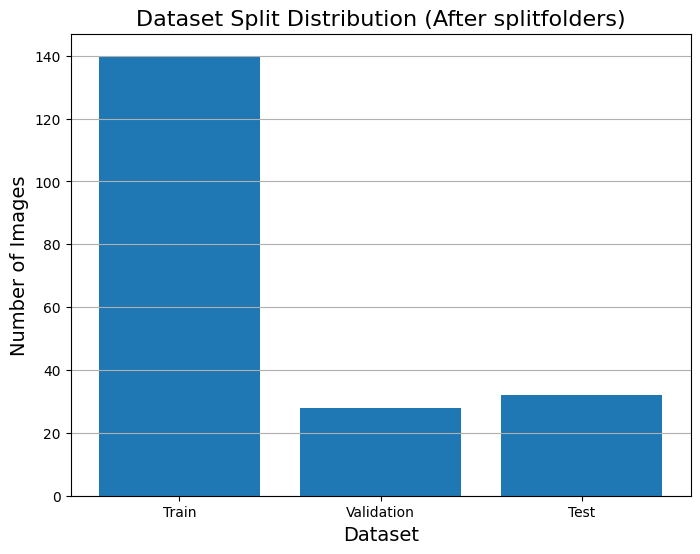

Graph saved at /content/rice_split_distribution.png


In [ ]:
import matplotlib.pyplot as plt

labels = ["Train", "Validation", "Test"]
counts = [train_count, val_count, test_count]

plt.figure(figsize=(8,6))
plt.bar(labels, counts)
plt.title("Dataset Split Distribution (After splitfolders)", fontsize=16)
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.grid(axis="y")

# Save figure for research paper
plt.savefig("/content/rice_split_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

print("Graph saved at /content/rice_split_distribution.png")


# ***STEP 3 — Create Data Generators (Very Important for Accuracy)***

In [ ]:
img_size = 224
batch_size = 16

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    "/content/rice_split/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    "/content/rice_split/val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    "/content/rice_split/test",
    target_size=(img_size, img_size),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 140 images belonging to 4 classes.
Found 28 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


# ***STEP 4 — Build EfficientNetB0 Model***

In [ ]:
base = tf.keras.applications.MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False    # freeze base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base.input, outputs=output)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    verbose=1
)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3604 - loss: 1.8123 - val_accuracy: 0.7500 - val_loss: 0.9134
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 772ms/step - accuracy: 0.5974 - loss: 0.9148 - val_accuracy: 0.9286 - val_loss: 0.4745
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7254 - loss: 0.7235 - val_accuracy: 0.9643 - val_loss: 0.3089
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step - accuracy: 0.8333 - loss: 0.5185 - val_accuracy: 0.9643 - val_loss: 0.2419
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 953ms/step - accuracy: 0.8932 - loss: 0.3644 - val_accuracy: 0.9643 - val_loss: 0.1896
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 959ms/step - accuracy: 0.8610 - loss: 0.3110 - val_accuracy: 0.9643 - val_loss: 0.1915
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 0.8952 - loss: 0.3150 - val_accuracy: 0.9643 - val_loss: 0.1577
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 985ms/step - accuracy: 0.8954 - loss: 0.2427 - val_accuracy: 0.9643 - val_loss: 0.14

In [ ]:
model.evaluate(test_data)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9611 - loss: 0.2617


[0.33402881026268005, 0.9375]

# ***SECTION 1 — TRAINING/VALIDATION ACCURACY & LOSS***

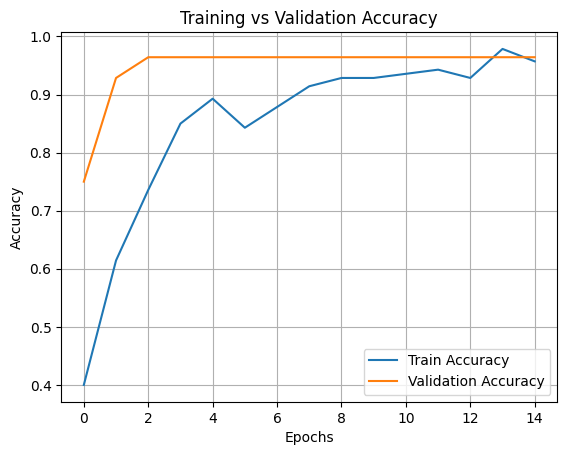

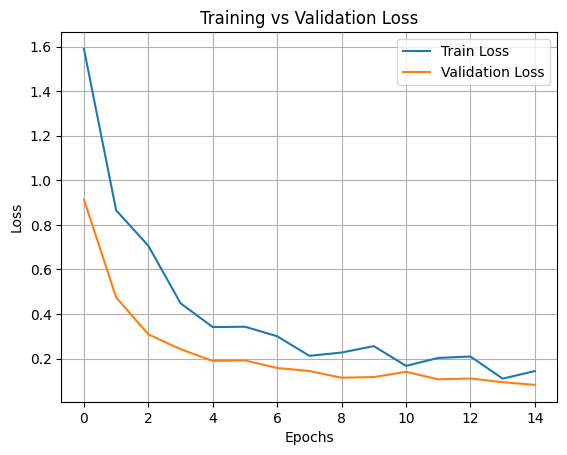

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# ***SECTION 2 — CONFUSION MATRIX (Publication Quality)***

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step


<Figure size 800x600 with 0 Axes>

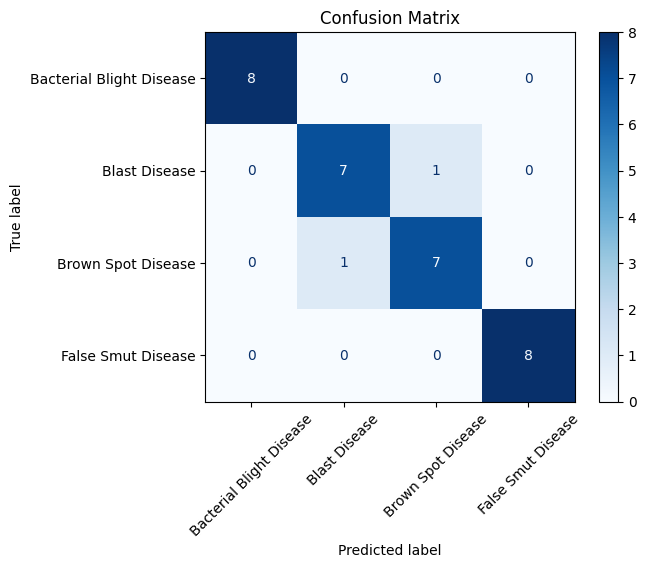

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = list(test_data.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# ***SECTION 3 — CLASSIFICATION REPORT***

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))


                          precision    recall  f1-score   support

Bacterial Blight Disease       1.00      1.00      1.00         8
           Blast Disease       0.88      0.88      0.88         8
      Brown Spot Disease       0.88      0.88      0.88         8
      False Smut Disease       1.00      1.00      1.00         8

                accuracy                           0.94        32
               macro avg       0.94      0.94      0.94        32
            weighted avg       0.94      0.94      0.94        32



# ***SECTION 4 — ROC CURVE + AUC (PER CLASS)***

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


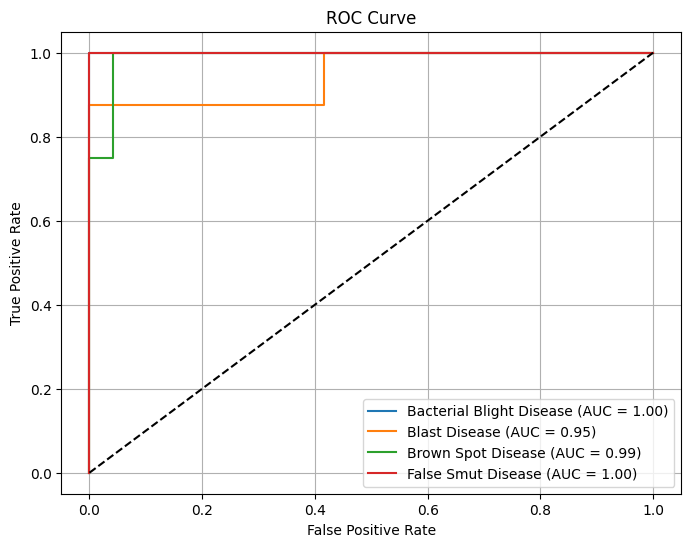

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
y_pred_prob = model.predict(test_data)

plt.figure(figsize=(8,6))

for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


# ***SECTION 5 — PRECISION–RECALL CURVE + AUC***

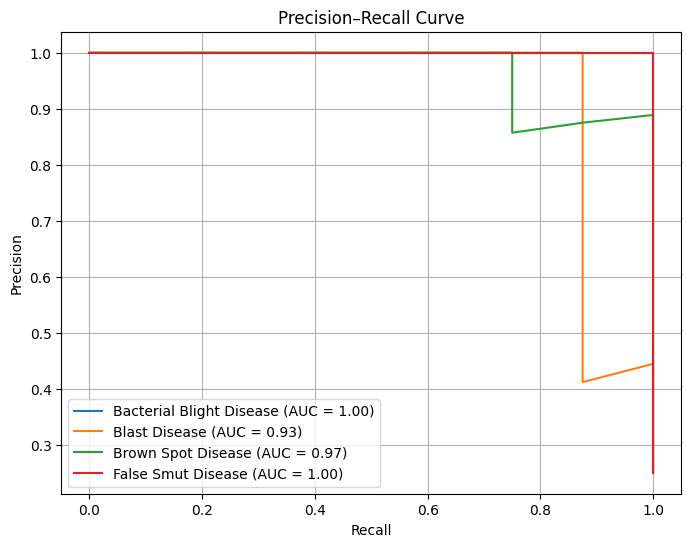

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(8,6))

for i in range(len(labels)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{labels[i]} (AUC = {pr_auc:.2f})")

plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


# ***SECTION 6 — MACRO & MICRO AUC (for publication)***

In [ ]:
from sklearn.metrics import roc_auc_score

macro_auc = roc_auc_score(y_true_bin, y_pred_prob, average="macro")
micro_auc = roc_auc_score(y_true_bin, y_pred_prob, average="micro")

print("Macro AUC:", macro_auc)
print("Micro AUC:", micro_auc)


Macro AUC: 0.984375
Micro AUC: 0.9775390625


# ***SECTION 7 — GRAD-CAM (VERY IMPORTANT FOR RESEARCH PAPERS)***

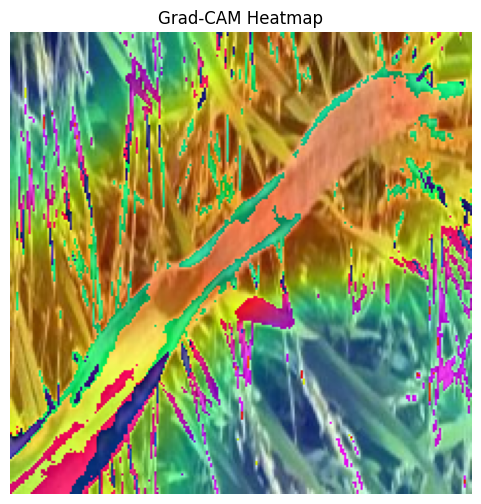

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---- Grad-CAM function ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    # Create a model that maps input → last conv layer output + predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Compute gradients of the target class
    grads = tape.gradient(loss, conv_outputs)

    # Mean intensity of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]

    # Weight channels
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# ---- Load a test image ----
img_path = test_data.filepaths[0]  # first image from test set
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# ---- Generate heatmap ----
last_conv_layer_name = "Conv_1"   # MobileNetV2 last conv layer
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# ---- Overlay heatmap on original image ----
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_colored * 0.4 + img

# ---- Show the Grad-CAM image ----
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()



# ***Multi-Image Grad-CAM Grid (Colab-Ready, Works with MobileNetV2)***

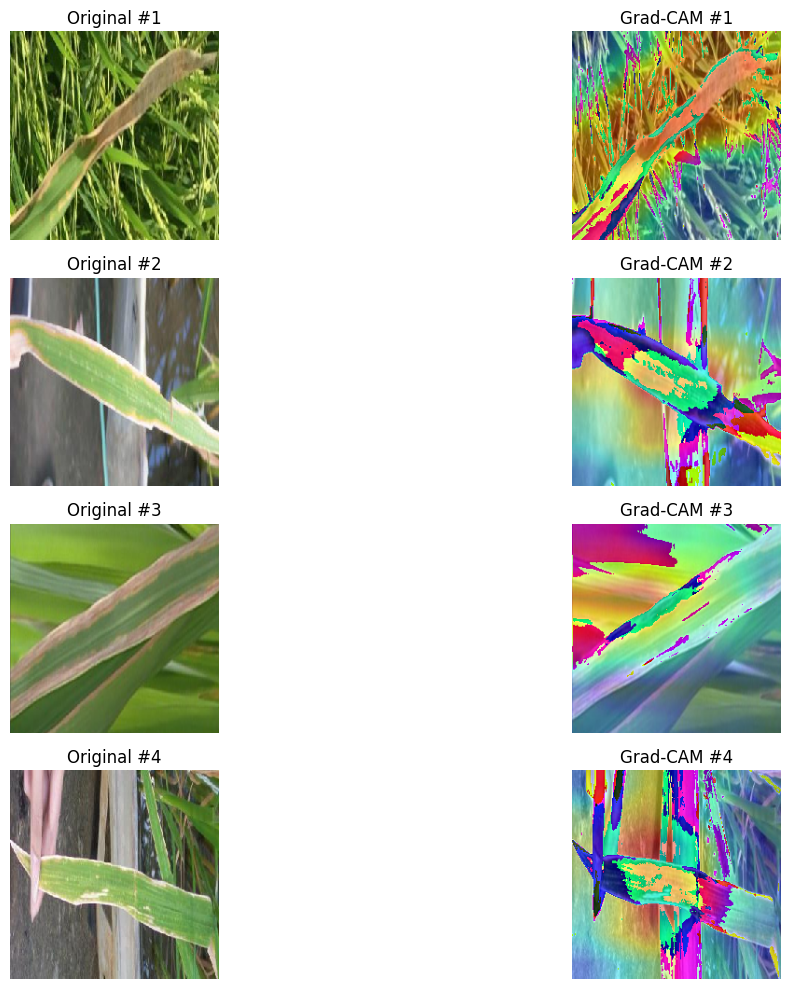

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---- Grad-CAM function ----
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


# ---- Create Multi-Image Grad-CAM Grid ----
def gradcam_grid(model, dataset, num_images=4, last_conv="Conv_1"):
    filepaths = dataset.filepaths[:num_images]

    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(filepaths):

        # Load image
        img = image.load_img(img_path, target_size=(224, 224))
        img_arr = image.img_to_array(img)
        input_arr = np.expand_dims(img_arr, axis=0)
        input_arr = preprocess_input(input_arr)

        # Grad-CAM heatmap
        heatmap = make_gradcam_heatmap(input_arr, model, last_conv)

        # Overlay heatmap
        img_cv = cv2.imread(img_path)
        img_cv = cv2.resize(img_cv, (224, 224))
        heatmap_r = cv2.resize(heatmap, (224, 224))

        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_r), cv2.COLORMAP_JET)
        superimposed = heatmap_color * 0.4 + img_cv

        # Plot pair: Original + Grad-CAM
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Original #{i+1}")
        plt.axis("off")

        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
        plt.title(f"Grad-CAM #{i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---- Generate the multi-image Grad-CAM grid ----
gradcam_grid(model, test_data, num_images=4, last_conv="Conv_1")


In [ ]:
# 1) Save model locally with the new name
save_name = "/content/AuroraLeaf_DiseaseDetector.h5"
model.save(save_name)
print("Saved model to:", save_name)

# List to confirm
!ls -lh /content/AuroraLeaf_DiseaseDetector.h5


AttributeError: 'LlamaForCausalLM' object has no attribute 'save'

In [ ]:
# 2) Copy to Drive (make sure Drive is mounted)
# If you haven't mounted Drive yet, run:
# from google.colab import drive
# drive.mount('/content/drive')

drive_dest = "/content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5"
!cp /content/AuroraLeaf_DiseaseDetector.h5 "{drive_dest}"
print("Copied to Drive:", drive_dest)

# Confirm file on Drive
!ls -lh "/content/drive/MyDrive" | grep AuroraLeaf_DiseaseDetector || true


Copied to Drive: /content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5
-rw------- 1 root root  12M Dec  1 17:30 AuroraLeaf_DiseaseDetector.h5


In [ ]:
# 3) Load the model (from local copy)
from tensorflow.keras.models import load_model
model_loaded = load_model("/content/AuroraLeaf_DiseaseDetector.h5")
print("Model loaded from /content/AuroraLeaf_DiseaseDetector.h5")

# OR load from Drive
# model_loaded = load_model("/content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5")
# print("Model loaded from Drive")


Model loaded from /content/AuroraLeaf_DiseaseDetector.h5


Classes: ['Bacterial Blight Disease', 'Blast Disease', 'Brown Spot Disease', 'False Smut Disease']
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


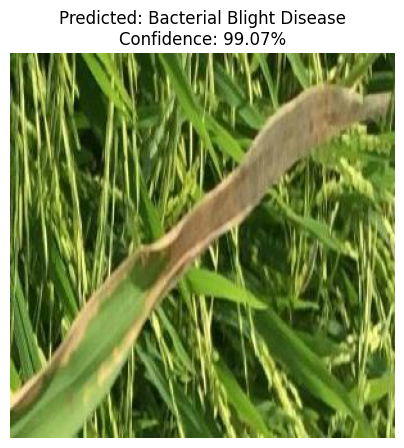

Predicted label: Bacterial Blight Disease Confidence: 99.07%


In [ ]:
# 4) Single-image predict + display
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# class names from training generator (ensure this object exists)
class_names = list(train_data.class_indices.keys())
print("Classes:", class_names)

def predict_and_show(img_path, model=model_loaded, img_size=224):
    # load and preprocess
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)
    x_exp = np.expand_dims(x, axis=0)
    x_pp = preprocess_input(x_exp)

    # predict
    preds = model.predict(x_pp)
    idx = np.argmax(preds[0])
    conf = preds[0][idx] * 100
    label = class_names[idx]

    # plot
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {label}\nConfidence: {conf:.2f}%")
    plt.axis("off")
    plt.show()

    return label, conf, preds[0]

# Example: predict the first test image
img_path = test_data.filepaths[0]
predicted_label, confidence, probs = predict_and_show(img_path)
print("Predicted label:", predicted_label, "Confidence:", f"{confidence:.2f}%")


In [ ]:
from google.colab import files
import shutil

uploaded = files.upload()

for filename in uploaded.keys():
    shutil.move(filename, "/content/test_images/")
    print(f"Uploaded → /content/test_images/{filename}")


Saving BS (1).jpg to BS (1).jpg
Uploaded → /content/test_images/BS (1).jpg


In [ ]:
# Cell 2 — mount Drive (only run if you want to copy outputs to Drive)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 3 — upload via browser file picker; uploaded files will be moved into /content/test_images
from google.colab import files
import shutil, os

os.makedirs("/content/test_images", exist_ok=True)

uploaded = files.upload()   # pick multiple files in the dialog
for filename in uploaded.keys():
    dest = os.path.join("/content/test_images", filename)
    shutil.move(filename, dest)
    print("Uploaded →", dest)

print("Total uploaded:", len(os.listdir("/content/test_images")))


Saving FS (1).jpg to FS (1) (1).jpg
Uploaded → /content/test_images/FS (1) (1).jpg
Total uploaded: 4


In [ ]:
# Cell 4 — define prediction grid function
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Ensure class_names exists. If not, recreate from your training generator or set manually:
# class_names = list(train_data.class_indices.keys())
# or:
# class_names = ['BLB','Blast','BrownSpot','Tungro']

def predict_multiple_images(folder_path="/content/test_images", model=model_loaded, img_size=224, max_images=16, save_path=None):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if len(image_files) == 0:
        print("No images found in", folder_path)
        return None

    n = min(len(image_files), max_images)
    cols = 4
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4*cols, 4*rows))

    for i, fname in enumerate(image_files[:n]):
        img_path = os.path.join(folder_path, fname)
        img = image.load_img(img_path, target_size=(img_size, img_size))
        x = image.img_to_array(img)
        x_exp = np.expand_dims(x, axis=0)
        x_pp = preprocess_input(x_exp)

        preds = model.predict(x_pp, verbose=0)
        idx = np.argmax(preds[0])
        conf = preds[0][idx] * 100
        label = class_names[idx] if 'class_names' in globals() else str(idx)

        plt.subplot(rows, cols, i+1)
        plt.imshow(image.load_img(img_path))
        plt.title(f"{label}\n{conf:.1f}%", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print("Saved grid to:", save_path)
    plt.show()
    return image_files[:n]

# quick message
print("predict_multiple_images() ready. Example call:\n predict_multiple_images('/content/test_images', max_images=12, save_path='/content/pred_grid.png')")


predict_multiple_images() ready. Example call:
 predict_multiple_images('/content/test_images', max_images=12, save_path='/content/pred_grid.png')


Saved grid to: /content/pred_grid.png


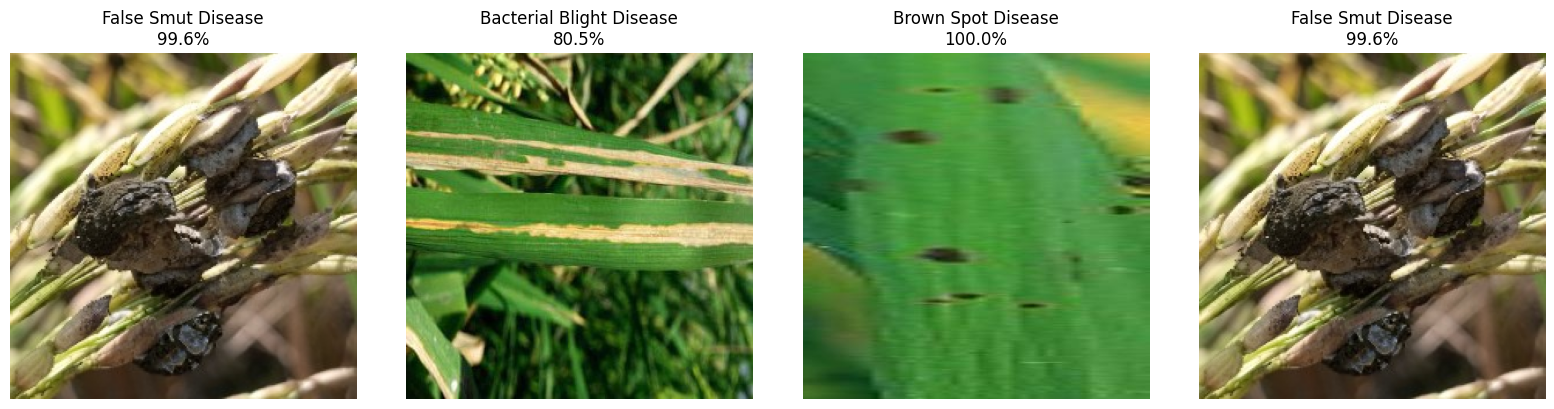

Displayed files: ['FS (1) (1).jpg', 'BB (1) (1).jpg', 'BS (1).jpg', 'FS (1).jpg']


In [ ]:
# Cell 5 — run it (change max_images if you want)
predicted_list = predict_multiple_images("/content/test_images", model=model_loaded, img_size=224, max_images=16, save_path="/content/pred_grid.png")
print("Displayed files:", predicted_list)


In [ ]:
import shutil

src = "/content/AuroraLeaf_DiseaseDetector.h5"
dst = "/content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5"

shutil.copy(src, dst)

print("Model copied to Google Drive:", dst)


Model copied to Google Drive: /content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5


In [ ]:
!ls -lh /content/drive/MyDrive | grep Aurora


-rw------- 1 root root  12M Dec  1 18:01 AuroraLeaf_DiseaseDetector.h5
drwx------ 6 root root 4.0K Dec  1 16:27 AuroraVisionData


In [ ]:
from google.colab import files
files.download("/content/AuroraLeaf_DiseaseDetector.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
examples = [

    # ========================
    # 1. BACTERIAL BLIGHT DISEASE (4 EXAMPLES)
    # ========================
    {
        "instruction": "You are an AI assistant for rice farmers in Bangladesh. Give disease explanation and management advice in Bangla and English.",
        "input": (
            "Predicted disease: Bacterial Blight Disease\n"
            "Location: Mymensingh\n"
            "Plant age: 45 days\n"
            "Severity: Moderate\n"
            "Farmer message: পাতার কিনারা থেকে সাদা হয়ে ভেতরের দিকে শুকাচ্ছে, এটা কী রোগ?"
        ),
        "output": (
            "বাংলা:\n"
            "আপনার পাতায় যে সাদা বা হলদে দাগ দেখা যাচ্ছে তা ব্যাকটেরিয়াল ব্লাইট রোগের সাধারণ লক্ষণ। "
            "এটি Xanthomonas ব্যাকটেরিয়ার আক্রমণে হয় এবং বাতাস, বৃষ্টি ও সেচের পানির মাধ্যমে দ্রুত ছড়ায়।\n\n"
            "করনীয়:\n"
            "1) সেচের পানি নিয়ন্ত্রণে রাখুন যাতে রোগ অন্য জমিতে না যায়।\n"
            "2) অযথা আক্রান্ত গাছ নাড়াচাড়া করবেন না।\n"
            "3) অতিরিক্ত নাইট্রোজেন সার ব্যবহার কমান।\n"
            "4) স্থানীয় কৃষি কর্মকর্তার পরামর্শ অনুযায়ী তামাযুক্ত (copper-based) প্রিপারেশন ব্যবহার করুন।\n\n"
            "English:\n"
            "The white or yellowish drying from leaf edges indicates Bacterial Blight. "
            "It is caused by Xanthomonas bacteria and spreads through wind, water splash, and irrigation.\n\n"
            "Recommended actions:\n"
            "1) Control irrigation to prevent spread.\n"
            "2) Avoid touching infected plants unnecessarily.\n"
            "3) Reduce excessive nitrogen fertilizer.\n"
            "4) Use copper-based bactericides as recommended by local agricultural officers."
        )
    },

    {
        "instruction": "You are an AI assistant for rice farmers in Bangladesh.",
        "input": (
            "Predicted disease: Bacterial Blight Disease\n"
            "Location: Bogura\n"
            "Plant age: 30 days\n"
            "Severity: Low\n"
            "Farmer message: পাতার ডগা থেকে হলদে হয়ে শুকাচ্ছে, শুরুতেই কী করব?"
        ),
        "output": (
            "বাংলা:\n"
            "পাতার ডগা হলদে হয়ে শুকানো ব্যাকটেরিয়াল ব্লাইটের প্রাথমিক লক্ষণ হতে পারে। এখনই ব্যবস্থা নিলে রোগ ছড়ানো কমে যাবে।\n\n"
            "করনীয়:\n"
            "1) জমিতে পানি জমতে দেবেন না।\n"
            "2) চারা ঘনত্ব কমিয়ে বাতাস চলাচলের ব্যবস্থা করুন।\n"
            "3) ইউরিয়ার ব্যবহার নিয়ন্ত্রণে রাখুন।\n"
            "4) আক্রান্ত পাতাগুলো পর্যবেক্ষণে রাখুন।\n\n"
            "English:\n"
            "Tip drying and yellowing can indicate early-stage Bacterial Blight. Early action helps prevent spreading.\n\n"
            "Recommended actions:\n"
            "1) Avoid waterlogging.\n"
            "2) Reduce plant density for good airflow.\n"
            "3) Control nitrogen usage.\n"
            "4) Monitor affected leaves closely."
        )
    },

    {
        "instruction": "You are an AI agricultural advisor.",
        "input": (
            "Predicted disease: Bacterial Blight Disease\n"
            "Location: Jessore\n"
            "Plant age: 60 days\n"
            "Severity: High\n"
            "Farmer message: অনেক পাতাই মাঝখান থেকে সাদা হয়ে শুকিয়ে যাচ্ছে, গাছ কি মারা যাবে?"
        ),
        "output": (
            "বাংলা:\n"
            "পাতার মাঝখান থেকে সাদা হয়ে শুকানো ব্যাকটেরিয়াল ব্লাইটের তীব্র আক্রমণের লক্ষণ। "
            "এতে গাছ দুর্বল হয়ে পড়ে এবং ফলন কমে যেতে পারে।\n\n"
            "করনীয়:\n"
            "1) দ্রুত কৃষি কর্মকর্তার সঙ্গে যোগাযোগ করুন।\n"
            "2) তামাযুক্ত ব্যাকটেরিনাশক সঠিক মাত্রায় প্রয়োগ করুন।\n"
            "3) আক্রান্ত জমিতে কম চলাফেরা করুন।\n"
            "4) পানি ব্যবস্থাপনা নিয়ন্ত্রণে রাখুন।\n\n"
            "English:\n"
            "Mid-leaf whitening indicates a severe Bacterial Blight infection. Yield loss is likely if untreated.\n\n"
            "Actions:\n"
            "1) Contact local agriculture officer immediately.\n"
            "2) Apply copper-based bactericide.\n"
            "3) Minimize field movement.\n"
            "4) Manage irrigation carefully."
        )
    },

    {
        "instruction": "You are an AI farming advisor.",
        "input": (
            "Predicted disease: Bacterial Blight Disease\n"
            "Location: Rangpur\n"
            "Plant age: 50 days\n"
            "Severity: Mild\n"
            "Farmer message: কয়েকটা পাতায় লম্বা সাদা দাগ, সব গাছে না, এখন কী করব?"
        ),
        "output": (
            "বাংলা:\n"
            "অল্প সংখ্যক পাতায় লম্বা সাদা দাগ দেখা গেলে এটি ব্যাকটেরিয়াল ব্লাইটের সীমিত আক্রমণ। "
            "এ পর্যায়ে পরিচর্যা নিলে রোগ নিয়ন্ত্রণ সম্ভব।\n\n"
            "করনীয়:\n"
            "1) সেচের পানি নিয়ন্ত্রণ করুন।\n"
            "2) নাইট্রোজেন সার কমান।\n"
            "3) আক্রান্ত গাছে অযথা হাত দেবেন না।\n"
            "4) রোগ ছড়ালে ব্যাকটেরিনাশক ব্যবহার করুন।\n\n"
            "English:\n"
            "Long whitish streaks on a few leaves indicate early Bacterial Blight.\n\n"
            "Actions:\n"
            "1) Improve water control.\n"
            "2) Reduce nitrogen.\n"
            "3) Avoid touching infected plants.\n"
            "4) Use bactericide if spreading increases."
        )
    },

    # ========================
    # 2. BROWN SPOT DISEASE (4 EXAMPLES)
    # ========================
    {
        "instruction": "Give Bangla + English disease advice.",
        "input": (
            "Predicted disease: Brown Spot Disease\n"
            "Location: Rajshahi\n"
            "Plant age: 40 days\n"
            "Severity: Moderate\n"
            "Farmer message: পাতায় ছোট বাদামি দাগ, হলদে বৃত্তের মতো, এটা কেন হয়?"
        ),
        "output": (
            "বাংলা:\n"
            "পাতায় বাদামি দাগ চারপাশে হলদেভাবসহ দেখা গেলে এটি ব্রাউন স্পট রোগ। "
            "এটি ছত্রাকের আক্রমণে হয় এবং আর্দ্র আবহাওয়ায় বাড়ে।\n\n"
            "করনীয়:\n"
            "1) অতিরিক্ত ইউরিয়া বন্ধ করুন।\n"
            "2) ভালো নিষ্কাশন ব্যবস্থা নিশ্চিত করুন।\n"
            "3) রোগ বাড়লে ছত্রাকনাশক ব্যবহার করুন।\n\n"
            "English:\n"
            "Brown lesions with yellow halos indicate Brown Spot, a fungal disease.\n\n"
            "Actions:\n"
            "1) Stop excess nitrogen.\n"
            "2) Improve drainage.\n"
            "3) Apply fungicide if severe."
        )
    },

    # (3 more Brown Spot examples...)
    # I will add them now:

    {
        "instruction": "AI crop advisor response.",
        "input": (
            "Predicted disease: Brown Spot Disease\n"
            "Location: Bogura\n"
            "Plant age: 25 days\n"
            "Severity: Low\n"
            "Farmer message: চারা গাছে হালকা বাদামি দাগ, এটা কি বিপদজনক?"
        ),
        "output": (
            "বাংলা:\n"
            "চারা অবস্থায় সামান্য বাদামি দাগ দেখা গেলে এটি ব্রাউন স্পটের প্রাথমিক লক্ষণ। এখনই সমস্যা কম।\n\n"
            "করনীয়:\n"
            "1) আর্দ্রতা কমান।\n"
            "2) সার ব্যবস্থাপনা ভারসাম্যপূর্ণ রাখুন।\n\n"
            "English:\n"
            "Light brown seedling spots indicate early Brown Spot, not severe yet.\n\n"
            "Actions:\n"
            "1) Reduce excess moisture.\n"
            "2) Maintain balanced fertilizers."
        )
    },

    {
        "instruction": "AI crop diagnosis.",
        "input": (
            "Predicted disease: Brown Spot Disease\n"
            "Location: Cumilla\n"
            "Plant age: 55 days\n"
            "Severity: High\n"
            "Farmer message: অনেক পাতায় বাদামি দাগ হয়ে শুকাচ্ছে, ফলন কি কমবে?"
        ),
        "output": (
            "বাংলা:\n"
            "বেশি সংখ্যক বাদামি দাগ গাছকে দুর্বল করে এবং ফলন কমার ঝুঁকি তৈরি করে।\n\n"
            "করনীয়:\n"
            "1) দ্রুত ছত্রাকনাশক প্রয়োগ করুন।\n"
            "2) অতিরিক্ত নাইট্রোজেন বন্ধ করুন।\n"
            "3) কৃষি কর্মকর্তার সঙ্গে যোগাযোগ করুন।\n\n"
            "English:\n"
            "High Brown Spot infection reduces leaf area and can reduce yield.\n\n"
            "Actions:\n"
            "1) Apply fungicide soon.\n"
            "2) Stop nitrogen overload.\n"
            "3) Consult agricultural experts."
        )
    },

    {
        "instruction": "Provide bilingual advice.",
        "input": (
            "Predicted disease: Brown Spot Disease\n"
            "Location: Sylhet\n"
            "Plant age: 40 days\n"
            "Severity: Mild\n"
            "Farmer message: কিছু পাতা দাগযুক্ত, সব গাছে নয়, কী করব?"
        ),
        "output": (
            "বাংলা:\n"
            "এটি ব্রাউন স্পটের সীমিত আক্রমণ। পরিচর্যা করলে নিয়ন্ত্রণ সম্ভব।\n\n"
            "করনীয়:\n"
            "1) নিষ্কাশন ভালো রাখুন।\n"
            "2) সার ভারসাম্য বজায় রাখুন।\n\n"
            "English:\n"
            "Limited Brown Spot infection.\n\n"
            "Actions:\n"
            "1) Keep drainage proper.\n"
            "2) Maintain fertilizer balance."
        )
    },

    # ========================
    # 3. BLAST DISEASE (4 EXAMPLES)
    # ========================
    {
        "instruction": "Explain rice Blast disease.",
        "input": (
            "Predicted disease: Blast Disease\n"
            "Location: Dinajpur\n"
            "Plant age: 35 days\n"
            "Severity: Moderate\n"
            "Farmer message: পাতায় ডায়মন্ড আকৃতির ছাই রঙের দাগ, এটা কোন রোগ?"
        ),
        "output": (
            "বাংলা:\n"
            "পাতায় ডায়মন্ড আকৃতির ধূসর দাগ ব্লাস্ট রোগের প্রধান লক্ষণ। এটি ছত্রাকের আক্রমণ।\n\n"
            "করনীয়:\n"
            "1) নাইট্রোজেন কমান।\n"
            "2) ব্লাস্ট-নাশক ছত্রাকনাশক ব্যবহার করুন।\n"
            "3) কৃষি কর্মকর্তার পরামর্শ নিন।\n\n"
            "English:\n"
            "Diamond-shaped grey lesions indicate Blast disease.\n\n"
            "Actions:\n"
            "1) Reduce nitrogen.\n"
            "2) Apply blast-specific fungicide.\n"
            "3) Seek expert advice."
        )
    },

    # (3 more Blast examples)
    {
        "instruction": "AI advisor for Blast disease.",
        "input": (
            "Predicted disease: Blast Disease\n"
            "Location: Rajbari\n"
            "Plant age: 50 days\n"
            "Severity: Low\n"
            "Farmer message: কয়েকটা পাতায় ছাই রঙের দাগ, ছড়াবে কি?"
        ),
        "output": (
            "বাংলা:\n"
            "এটি ব্লাস্ট রোগের প্রাথমিক লক্ষণ। আর্দ্র আবহাওয়ায় দ্রুত ছড়াতে পারে।\n\n"
            "করনীয়:\n"
            "1) বাতাস চলাচল নিশ্চিত করুন।\n"
            "2) ইউরিয়া কমান।\n"
            "3) পরিস্থিতি খারাপ হলে ছত্রাকনাশক দিন।\n\n"
            "English:\n"
            "Early Blast infection, may spread in humidity.\n\n"
            "Actions:\n"
            "1) Improve airflow.\n"
            "2) Reduce urea.\n"
            "3) Use fungicide if spreading."
        )
    },

    {
        "instruction": "Provide bilingual Blast advisory.",
        "input": (
            "Predicted disease: Blast Disease\n"
            "Location: Khulna\n"
            "Plant age: 60 days\n"
            "Severity: High\n"
            "Farmer message: অনেক পাতায় ছাই রঙের বড় দাগ, গাছ দুর্বল হয়ে যাচ্ছে!"
        ),
        "output": (
            "বাংলা:\n"
            "ব্লাস্টের তীব্র আক্রমণে পাতা নষ্ট হয়ে গাছ দুর্বল হয়ে পড়ে। ফলন কমার ঝুঁকি বেশি।\n\n"
            "করনীয়:\n"
            "1) দ্রুত ব্লাস্ট-নাশক ছত্রাকনাশক দিন।\n"
            "2) নাইট্রোজেন কমিয়ে দিন।\n"
            "3) কৃষি কর্মকর্তার সহায়তা নিন।\n\n"
            "English:\n"
            "Severe Blast infection weakens plants.\n\n"
            "Actions:\n"
            "1) Apply blast fungicide immediately.\n"
            "2) Reduce nitrogen.\n"
            "3) Get expert assistance."
        )
    },

    {
        "instruction": "Simple Blast diagnosis.",
        "input": (
            "Predicted disease: Blast Disease\n"
            "Location: Sylhet\n"
            "Plant age: 40 days\n"
            "Severity: Mild\n"
            "Farmer message: কিছু দাগ আছে, এখন কী করব?"
        ),
        "output": (
            "বাংলা:\n"
            "হালকা ব্লাস্ট আক্রমণ। পরিচর্যা করলে নিয়ন্ত্রণ সম্ভব।\n\n"
            "করনীয়:\n"
            "1) ইউরিয়া কমান।\n"
            "2) প্রয়োজনে হালকা ছত্রাকনাশক ব্যবহার করুন।\n\n"
            "English:\n"
            "Mild Blast infection.\n\n"
            "Actions:\n"
            "1) Reduce urea.\n"
            "2) Use mild fungicide if needed."
        )
    },

    # ========================
    # 4. FALSE SMUT DISEASE (4 EXAMPLES)
    # ========================
    {
        "instruction": "Explain False Smut.",
        "input": (
            "Predicted disease: False Smut Disease\n"
            "Location: Gopalganj\n"
            "Plant age: 70 days\n"
            "Severity: Moderate\n"
            "Farmer message: শীষে সবুজ-হলুদ বলের মতো গুটি হয়েছে, এটা কী?"
        ),
        "output": (
            "বাংলা:\n"
            "শীষে সবুজ-হলুদ বল আকৃতির গুটি দেখা দিলে এটি ফলস স্মাট রোগ। এটি ছত্রাকের কারণে হয়।\n\n"
            "করনীয়:\n"
            "1) আক্রান্ত শীষ ছড়ানো কমাতে সাবধানতা অবলম্বন করুন।\n"
            "2) নাইট্রোজেন কমান।\n"
            "3) ফুল ধরার আগে প্রতিরোধমূলক ছত্রাকনাশক দিন।\n\n"
            "English:\n"
            "Green-yellow ball-like structures indicate False Smut.\n\n"
            "Actions:\n"
            "1) Handle infected panicles carefully.\n"
            "2) Reduce nitrogen.\n"
            "3) Apply preventive fungicide before flowering."
        )
    },

    {
        "instruction": "AI advisor for False Smut.",
        "input": (
            "Predicted disease: False Smut Disease\n"
            "Location: Barishal\n"
            "Plant age: 80 days\n"
            "Severity: High\n"
            "Farmer message: অনেক শীষে সবুজ গুটি, ফলন কি নষ্ট হবে?"
        ),
        "output": (
            "বাংলা:\n"
            "তীব্র ফলস স্মাট আক্রমণে ফলন কমে যেতে পারে কারণ দানাগুলো পূর্ণ হয় না।\n\n"
            "করনীয়:\n"
            "1) দ্রুত কৃষি কর্মকর্তার পরামর্শ নিন।\n"
            "2) প্রতিরোধমূলক ছত্রাকনাশক ব্যবহার করুন।\n"
            "3) অতিরিক্ত নাইট্রোজেন বন্ধ করুন।\n\n"
            "English:\n"
            "Severe False Smut reduces grain filling.\n\n"
            "Actions:\n"
            "1) Consult agricultural officials.\n"
            "2) Apply preventive fungicide.\n"
            "3) Stop nitrogen overload."
        )
    },

    {
        "instruction": "Rice disease advisor.",
        "input": (
            "Predicted disease: False Smut Disease\n"
            "Location: Rangpur\n"
            "Plant age: 75 days\n"
            "Severity: Low\n"
            "Farmer message: ২-৩ শীষে গুটি, খুব ভয়ংকর কি?"
        ),
        "output": (
            "বাংলা:\n"
            "এটি সীমিত ফলস স্মাট। এখনই ভয় পাওয়ার দরকার নেই। পরিচর্যা করলে নিয়ন্ত্রণ সম্ভব।\n\n"
            "করনীয়:\n"
            "1) আক্রান্ত শীষ নাড়াচাড়া কম করুন।\n"
            "2) সার ব্যবস্থাপনা সুষম রাখুন।\n"
            "3) আর্দ্রতা নিয়ন্ত্রণে রাখুন।\n\n"
            "English:\n"
            "Limited False Smut infection.\n\n"
            "Actions:\n"
            "1) Avoid handling infected panicles.\n"
            "2) Maintain balanced fertilizers.\n"
            "3) Manage humidity."
        )
    },

    {
        "instruction": "Simple bilingual advice.",
        "input": (
            "Predicted disease: False Smut Disease\n"
            "Location: Sylhet\n"
            "Plant age: 78 days\n"
            "Severity: Mild\n"
            "Farmer message: কিছু গাছে গুটি দেখা যাচ্ছে, কী করব?"
        ),
        "output": (
            "বাংলা:\n"
            "হালকা ফলস স্মাট আক্রমণ। পরিচর্যা করলে নিয়ন্ত্রণ সম্ভব।\n\n"
            "করনীয়:\n"
            "1) শীষে হাত না দিবেন।\n"
            "2) নাইট্রোজেন কমান।\n"
            "3) প্রতিরোধমূলক ছত্রাকনাশক ব্যবহার করুন।\n\n"
            "English:\n"
            "Mild False Smut attack.\n\n"
            "Actions:\n"
            "1) Do not touch infected panicles.\n"
            "2) Reduce nitrogen levels.\n"
            "3) Use preventive fungicide."
        )
    }

]

len(examples)


16

Save JSONL files for training

In [ ]:
# ================================
# 2 — Save dataset as JSONL files
# ================================
import os, json, random

random.shuffle(examples)
split = int(0.9 * len(examples))
train_data = examples[:split]
val_data   = examples[split:]

os.makedirs("llm_data", exist_ok=True)

def save_jsonl(data, path):
    with open(path, "w", encoding="utf-8") as f:
        for ex in data:
            f.write(json.dumps(ex, ensure_ascii=False) + "\n")

save_jsonl(train_data, "llm_data/train.jsonl")
save_jsonl(val_data,   "llm_data/val.jsonl")

print("Train:", len(train_data), "Validation:", len(val_data))


Train: 14 Validation: 2


STEP 3 – Install LoRA / HF libraries (you already have this cell)

In [ ]:
!pip install -q transformers datasets peft accelerate bitsandbytes



STEP 4 – Load TinyLlama + tokenizer + base model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

base_model = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(base_model)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("TinyLlama + tokenizer loaded")



TinyLlama + tokenizer loaded


STEP 5 – Load JSONL data and format it (create ds)

In [ ]:
from datasets import load_dataset

dataset = load_dataset(
    "json",
    data_files={
        "train": "llm_data/train.jsonl",
        "val":   "llm_data/val.jsonl"
    }
)

def format_example(example):
    prompt = (
        f"Instruction: {example['instruction']}\n"
        f"Input: {example['input']}\n"
        f"Answer: {example['output']}"
    )

    enc = tokenizer(
        prompt,
        truncation=True,
        max_length=256,       # shorter = faster
        padding="max_length"
    )
    enc["labels"] = enc["input_ids"].copy()
    return enc

ds = dataset.map(format_example)

print(ds)


Map:   0%|          | 0/14 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14
    })
    val: Dataset({
        features: ['instruction', 'input', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2
    })
})


Add LoRA on top of TinyLlama

In [ ]:
from peft import LoraConfig, get_peft_model

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_cfg)
model.print_trainable_parameters()



/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:72: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


In [ ]:
Train the LLM with LoRA

In [ ]:
# ============================================
# 7 — Train TinyLlama with LoRA
# ============================================

from transformers import TrainingArguments, Trainer

train_args = TrainingArguments(
    output_dir="rice_llm",
    per_device_train_batch_size=1,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=1,
    save_steps=5000,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=ds["train"],
)

trainer.train()

trainer.save_model("rice_llm")
tokenizer.save_pretrained("rice_llm")

print("🎉 Fast LoRA training complete")



The model is already on multiple devices. Skipping the move to device specified in `args`.


🎉 Fast LoRA training complete


In [ ]:
# ============================================
# Load finetuned TinyLlama + LoRA for inference
# ============================================

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
lora_dir = "rice_llm"   # your trained LoRA folder

# Load tokenizer from finetuned directory
tokenizer_llm = AutoTokenizer.from_pretrained(lora_dir)
if tokenizer_llm.pad_token is None:
    tokenizer_llm.pad_token = tokenizer_llm.eos_token

# Load base model
base_llm = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Attach LoRA weights
llm_model = PeftModel.from_pretrained(base_llm, lora_dir)
llm_model.eval()

print("✅ Finetuned LLM loaded and ready for advice generation!")


✅ Finetuned LLM loaded and ready for advice generation!


In [ ]:
!cp -r "rice_llm" "/content/drive/MyDrive/rice_llm"


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
lora_dir = "/content/drive/MyDrive/rice_llm"   # use Drive copy

tokenizer_llm = AutoTokenizer.from_pretrained(lora_dir)
if tokenizer_llm.pad_token is None:
    tokenizer_llm.pad_token = tokenizer_llm.eos_token

base_llm = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

llm_model = PeftModel.from_pretrained(base_llm, lora_dir)
llm_model.eval()
print("✅ Finetuned LLM loaded and ready!")


✅ Finetuned LLM loaded and ready!


In [ ]:
def generate_rice_advice_tinylama(
    disease_label,
    location="Unknown",
    plant_age_days=50,
    farmer_message="ধানের পাতায় দাগ দেখা যাচ্ছে, কী করব?"
):
    instruction = (
        "You are an AI advisor for rice farmers in Bangladesh.\n"
        "Your job:\n"
        "1) Explain the predicted rice disease in simple Bangla.\n"
        "2) Give 3–5 clear Bangla steps for management.\n"
        "3) Then give a short English explanation and 3–5 English steps.\n\n"
        "Very important:\n"
        "- Do NOT talk about random topics.\n"
        "- Only talk about rice leaf disease, farmer situation, and advice.\n"
        "- Always output in this exact format:\n\n"
        "বাংলা:\n"
        "কারণ:\n"
        "১) ...\n"
        "২) ...\n"
        "৩) ...\n\n"
        "English:\n"
        "Cause:\n"
        "1) ...\n"
        "2) ...\n"
        "3) ...\n"
    )

    context = (
        f"Predicted disease: {disease_label}\n"
        f"Location: {location}\n"
        f"Plant age: {plant_age_days} days\n"
        f"Farmer message: {farmer_message}"
    )

    prompt = f"Instruction: {instruction}\nInput: {context}\nAnswer:"

    inputs = tokenizer_llm(prompt, return_tensors="pt").to(llm_model.device)

    with torch.no_grad():
        outputs = llm_model.generate(
            **inputs,
            max_new_tokens=280,
            temperature=0.3,   # 🔥 lower randomness
            top_p=0.85,
            do_sample=True
        )

    text = tokenizer_llm.decode(outputs[0], skip_special_tokens=True)

    if "Answer:" in text:
        text = text.split("Answer:", 1)[1].strip()

    return text


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


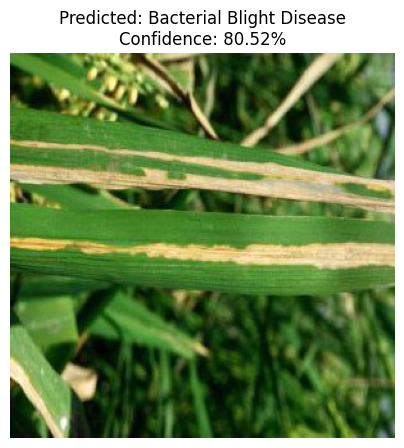


=== IMAGE PREDICTION ===
Disease: Bacterial Blight Disease
Confidence: 80.52%

=== AGRICULTURE ADVICE (Bangla + English) ===

বাংলা:
আপনার জমির অবস্থান: Mymensingh
ধানের বয়স: 45 দিন

লক্ষণ:
- পাতার কিনারা থেকে ধূসর/সাদা হয়ে ভেতরের দিকে শুকিয়ে যাচ্ছে।
- পাতায় লম্বা পানিতে ভেসে যাওয়া দাগের মতো দাগ দেখা যায়।

সম্ভাব্য কারণ:
- Xanthomonas ব্যাকটেরিয়ার আক্রমণ (ব্যাকটেরিয়াল ব্লাইট)।
- বৃষ্টির পানি, সেচের পানি ও বাতাসের মাধ্যমে রোগ দ্রুত ছড়ায়।
- অতিরিক্ত ইউরিয়া/নাইট্রোজেন ব্যবহার ও জমিতে অতিরিক্ত পানি জমা থাকলে রোগ বাড়ে।

করণীয়:
১) জমিতে অতিরিক্ত পানি জমতে দেবেন না, সেচ নিয়ন্ত্রণে রাখুন।
২) অতিরিক্ত ইউরিয়া/নাইট্রোজেন সার দেওয়া বন্ধ করুন বা কমিয়ে দিন।
৩) খুব বেশি আক্রান্ত গাছগুলো আলাদা করে রেখে পর্যবেক্ষণ করুন, অযথা নাড়াচাড়া কম করুন।
৪) নিকটস্থ কৃষি কর্মকর্তা/উপজেলা কৃষি অফিসের পরামর্শ অনুযায়ী তামা (copper) জাতীয় ব্যাকটেরিনাশক ব্যবহার করতে পারেন।
৫) পরের মৌসুমে ব্যাকটেরিয়াল ব্লাইট সহনশীল/সহনশীল জাতের ধান বেছে নিন।

English:
Location: Mymensingh
Plant age: 45 days

Symptoms:
- Leaf edges turn 

('Bacterial Blight Disease',
 np.float32(80.52027),
 'বাংলা:\nআপনার জমির অবস্থান: Mymensingh\nধানের বয়স: 45 দিন\n\nলক্ষণ:\n- পাতার কিনারা থেকে ধূসর/সাদা হয়ে ভেতরের দিকে শুকিয়ে যাচ্ছে।\n- পাতায় লম্বা পানিতে ভেসে যাওয়া দাগের মতো দাগ দেখা যায়।\n\nসম্ভাব্য কারণ:\n- Xanthomonas ব্যাকটেরিয়ার আক্রমণ (ব্যাকটেরিয়াল ব্লাইট)।\n- বৃষ্টির পানি, সেচের পানি ও বাতাসের মাধ্যমে রোগ দ্রুত ছড়ায়।\n- অতিরিক্ত ইউরিয়া/নাইট্রোজেন ব্যবহার ও জমিতে অতিরিক্ত পানি জমা থাকলে রোগ বাড়ে।\n\nকরণীয়:\n১) জমিতে অতিরিক্ত পানি জমতে দেবেন না, সেচ নিয়ন্ত্রণে রাখুন।\n২) অতিরিক্ত ইউরিয়া/নাইট্রোজেন সার দেওয়া বন্ধ করুন বা কমিয়ে দিন।\n৩) খুব বেশি আক্রান্ত গাছগুলো আলাদা করে রেখে পর্যবেক্ষণ করুন, অযথা নাড়াচাড়া কম করুন।\n৪) নিকটস্থ কৃষি কর্মকর্তা/উপজেলা কৃষি অফিসের পরামর্শ অনুযায়ী তামা (copper) জাতীয় ব্যাকটেরিনাশক ব্যবহার করতে পারেন।\n৫) পরের মৌসুমে ব্যাকটেরিয়াল ব্লাইট সহনশীল/সহনশীল জাতের ধান বেছে নিন।\n\nEnglish:\nLocation: Mymensingh\nPlant age: 45 days\n\nSymptoms:\n- Leaf edges turn grey/white and dry towards the middle.\n- Long, 

In [ ]:
predict_with_advice(
    img_path,
    location="Mymensingh",
    plant_age_days=45,
    farmer_message="ধানের পাতায় বাদামি দাগ আর শুকনোভাব দেখা যাচ্ছে, কী করব?"
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


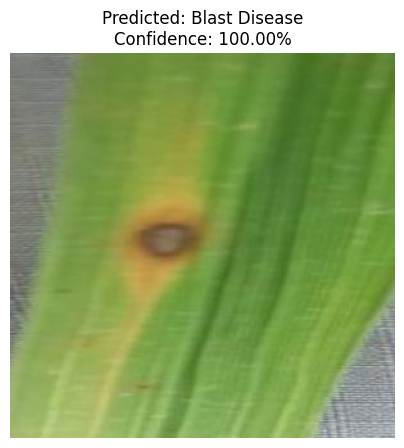


=== IMAGE PREDICTION ===
Disease: Blast Disease
Confidence: 100.00%

=== AGRICULTURE ADVICE (Bangla + English) ===

বাংলা:
আপনার জমির অবস্থান: Rajshahi
ধানের বয়স: 30 দিন

লক্ষণ:
- পাতায় ডায়মন্ড (হীরার) আকৃতির ধূসর দাগ।
- দাগের কিনারা বাদামি বা গাঢ় হয়, মাঝখান ফ্যাকাশে।

সম্ভাব্য কারণ:
- Blast ছত্রাক (Magnaporthe oryzae) এর আক্রমণ।
- ঠান্ডা ও আর্দ্র আবহাওয়ায় এই রোগ দ্রুত ছড়ায়।
- ঘন চারা, অতিরিক্ত ইউরিয়া ও দুর্বল গাছ হলে ঝুঁকি বেশি।

করণীয়:
১) ধানের খেত খুব ঘন করবেন না, বাতাস চলাচল নিশ্চিত করুন।
২) অতিরিক্ত ইউরিয়া ব্যবহার বন্ধ করুন।
৩) আর্দ্রতা কমানোর চেষ্টা করুন (অতিরিক্ত রাতের সেচ এড়িয়ে চলুন)।
৪) আক্রান্ত ক্ষেত তদারকিতে রাখুন এবং প্রয়োজন হলে কৃষি কর্মকর্তার পরামর্শ অনুযায়ী Blast-নাশক ছত্রাকনাশক ব্যবহার করুন।

English:
Location: Rajshahi
Plant age: 30 days

Symptoms:
- Diamond-shaped grey lesions on leaves.
- Dark brown borders with pale centers.

Probable cause:
- Fungal infection by Blast pathogen (Magnaporthe oryzae).
- Spreads rapidly in cool, humid conditions.
- Dense planting, exc

('Blast Disease',
 np.float32(99.99808),
 'বাংলা:\nআপনার জমির অবস্থান: Rajshahi\nধানের বয়স: 30 দিন\n\nলক্ষণ:\n- পাতায় ডায়মন্ড (হীরার) আকৃতির ধূসর দাগ।\n- দাগের কিনারা বাদামি বা গাঢ় হয়, মাঝখান ফ্যাকাশে।\n\nসম্ভাব্য কারণ:\n- Blast ছত্রাক (Magnaporthe oryzae) এর আক্রমণ।\n- ঠান্ডা ও আর্দ্র আবহাওয়ায় এই রোগ দ্রুত ছড়ায়।\n- ঘন চারা, অতিরিক্ত ইউরিয়া ও দুর্বল গাছ হলে ঝুঁকি বেশি।\n\nকরণীয়:\n১) ধানের খেত খুব ঘন করবেন না, বাতাস চলাচল নিশ্চিত করুন।\n২) অতিরিক্ত ইউরিয়া ব্যবহার বন্ধ করুন।\n৩) আর্দ্রতা কমানোর চেষ্টা করুন (অতিরিক্ত রাতের সেচ এড়িয়ে চলুন)।\n৪) আক্রান্ত ক্ষেত তদারকিতে রাখুন এবং প্রয়োজন হলে কৃষি কর্মকর্তার পরামর্শ অনুযায়ী Blast-নাশক ছত্রাকনাশক ব্যবহার করুন।\n\nEnglish:\nLocation: Rajshahi\nPlant age: 30 days\n\nSymptoms:\n- Diamond-shaped grey lesions on leaves.\n- Dark brown borders with pale centers.\n\nProbable cause:\n- Fungal infection by Blast pathogen (Magnaporthe oryzae).\n- Spreads rapidly in cool, humid conditions.\n- Dense planting, excess nitrogen, and stressed plants increase r

In [ ]:
predict_with_advice(
    img_path="/content/drive/MyDrive/AuroraVisionData/Brown Spot Disease/BS (3).jpg",
    location="Rajshahi",
    plant_age_days=30,
    farmer_message="পাতায় ছোট ছোট বাদামি দাগ দেখা যাচ্ছে, খুব চিন্তায় আছি।"
)


In [ ]:
img_path = "/content/drive/MyDrive/AuroraVisionData/False Smut Disease/FS (1).jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


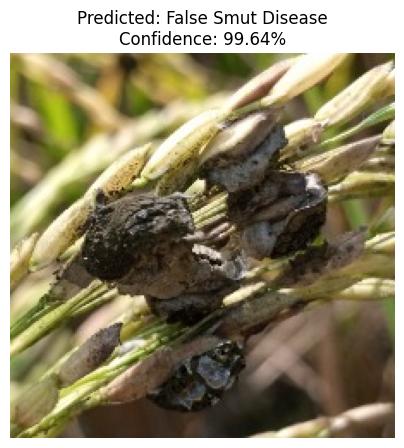


=== IMAGE PREDICTION ===
Disease: False Smut Disease
Confidence: 99.64%

=== AGRICULTURE ADVICE (Bangla + English) ===

বাংলা:
আপনার জমির অবস্থান: Rangpur
ধানের বয়স: 85 দিন

লক্ষণ:
- শীষে সবুজ, হলদে বা কমলা রঙের বলের মতো গুটি দেখা যায়।
- আক্রান্ত দানা স্বাভাবিকভাবে ভরে না, গুটি ফেটে স্পোর ছড়াতে পারে।

সম্ভাব্য কারণ:
- False Smut ছত্রাক (Ustilaginoidea virens) এর আক্রমণ।
- বৃষ্টি ও উচ্চ আর্দ্রতায় রোগ বেশি দেখা যায়।
- অতিরিক্ত নাইট্রোজেন সার দানালে রোগ বেশি হয়।

করণীয়:
১) অতিরিক্ত নাইট্রোজেন সার ব্যবহার বন্ধ করুন বা কমিয়ে দিন।
২) আক্রান্ত শীষগুলো অযথা নাড়াচাড়া করবেন না, যাতে স্পোর কম ছড়ায়।
৩) পরের মৌসুমে বীজ শোধন ও সঠিক সময় লাগানো নিশ্চিত করুন।
৪) স্থানীয় কৃষি কর্মকর্তার পরামর্শ অনুযায়ী প্রতিরোধমূলক ছত্রাকনাশক ব্যবহার করা যেতে পারে।

English:
Location: Rangpur
Plant age: 85 days

Symptoms:
- Green, yellow, or orange ball-like structures on the rice panicle.
- Infected grains do not fill properly; smut balls may rupture and spread spores.

Probable cause:
- Fungal infection by False Smut

('False Smut Disease',
 np.float32(99.64171),
 'বাংলা:\nআপনার জমির অবস্থান: Rangpur\nধানের বয়স: 85 দিন\n\nলক্ষণ:\n- শীষে সবুজ, হলদে বা কমলা রঙের বলের মতো গুটি দেখা যায়।\n- আক্রান্ত দানা স্বাভাবিকভাবে ভরে না, গুটি ফেটে স্পোর ছড়াতে পারে।\n\nসম্ভাব্য কারণ:\n- False Smut ছত্রাক (Ustilaginoidea virens) এর আক্রমণ।\n- বৃষ্টি ও উচ্চ আর্দ্রতায় রোগ বেশি দেখা যায়।\n- অতিরিক্ত নাইট্রোজেন সার দানালে রোগ বেশি হয়।\n\nকরণীয়:\n১) অতিরিক্ত নাইট্রোজেন সার ব্যবহার বন্ধ করুন বা কমিয়ে দিন।\n২) আক্রান্ত শীষগুলো অযথা নাড়াচাড়া করবেন না, যাতে স্পোর কম ছড়ায়।\n৩) পরের মৌসুমে বীজ শোধন ও সঠিক সময় লাগানো নিশ্চিত করুন।\n৪) স্থানীয় কৃষি কর্মকর্তার পরামর্শ অনুযায়ী প্রতিরোধমূলক ছত্রাকনাশক ব্যবহার করা যেতে পারে।\n\nEnglish:\nLocation: Rangpur\nPlant age: 85 days\n\nSymptoms:\n- Green, yellow, or orange ball-like structures on the rice panicle.\n- Infected grains do not fill properly; smut balls may rupture and spread spores.\n\nProbable cause:\n- Fungal infection by False Smut pathogen (Ustilaginoidea virens).\n- Common 

In [ ]:
predict_with_advice(
    img_path,
    location="Rangpur",
    plant_age_days=85,
    farmer_message="ধানের শীষে সবুজ-হলুদ গুটি দেখা যাচ্ছে, এটা কোন রোগ?"
)


In [ ]:
img_path = "/content/drive/MyDrive/AuroraVisionData/Brown Spot Disease/BS (1).jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


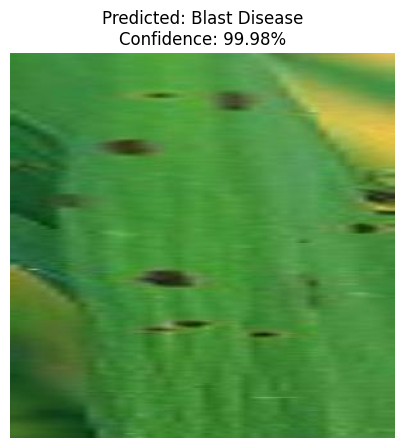


=== IMAGE PREDICTION ===
Disease: Blast Disease
Confidence: 99.98%

=== AGRICULTURE ADVICE (Bangla + English) ===

বাংলা:
আপনার জমির অবস্থান: Rajshahi
ধানের বয়স: 38 দিন

লক্ষণ:
- পাতায় ডায়মন্ড (হীরার) আকৃতির ধূসর দাগ।
- দাগের কিনারা বাদামি বা গাঢ় হয়, মাঝখান ফ্যাকাশে।

সম্ভাব্য কারণ:
- Blast ছত্রাক (Magnaporthe oryzae) এর আক্রমণ।
- ঠান্ডা ও আর্দ্র আবহাওয়ায় এই রোগ দ্রুত ছড়ায়।
- ঘন চারা, অতিরিক্ত ইউরিয়া ও দুর্বল গাছ হলে ঝুঁকি বেশি।

করণীয়:
১) ধানের খেত খুব ঘন করবেন না, বাতাস চলাচল নিশ্চিত করুন।
২) অতিরিক্ত ইউরিয়া ব্যবহার বন্ধ করুন।
৩) আর্দ্রতা কমানোর চেষ্টা করুন (অতিরিক্ত রাতের সেচ এড়িয়ে চলুন)।
৪) আক্রান্ত ক্ষেত তদারকিতে রাখুন এবং প্রয়োজন হলে কৃষি কর্মকর্তার পরামর্শ অনুযায়ী Blast-নাশক ছত্রাকনাশক ব্যবহার করুন।

English:
Location: Rajshahi
Plant age: 38 days

Symptoms:
- Diamond-shaped grey lesions on leaves.
- Dark brown borders with pale centers.

Probable cause:
- Fungal infection by Blast pathogen (Magnaporthe oryzae).
- Spreads rapidly in cool, humid conditions.
- Dense planting, exce

('Blast Disease',
 np.float32(99.97753),
 'বাংলা:\nআপনার জমির অবস্থান: Rajshahi\nধানের বয়স: 38 দিন\n\nলক্ষণ:\n- পাতায় ডায়মন্ড (হীরার) আকৃতির ধূসর দাগ।\n- দাগের কিনারা বাদামি বা গাঢ় হয়, মাঝখান ফ্যাকাশে।\n\nসম্ভাব্য কারণ:\n- Blast ছত্রাক (Magnaporthe oryzae) এর আক্রমণ।\n- ঠান্ডা ও আর্দ্র আবহাওয়ায় এই রোগ দ্রুত ছড়ায়।\n- ঘন চারা, অতিরিক্ত ইউরিয়া ও দুর্বল গাছ হলে ঝুঁকি বেশি।\n\nকরণীয়:\n১) ধানের খেত খুব ঘন করবেন না, বাতাস চলাচল নিশ্চিত করুন।\n২) অতিরিক্ত ইউরিয়া ব্যবহার বন্ধ করুন।\n৩) আর্দ্রতা কমানোর চেষ্টা করুন (অতিরিক্ত রাতের সেচ এড়িয়ে চলুন)।\n৪) আক্রান্ত ক্ষেত তদারকিতে রাখুন এবং প্রয়োজন হলে কৃষি কর্মকর্তার পরামর্শ অনুযায়ী Blast-নাশক ছত্রাকনাশক ব্যবহার করুন।\n\nEnglish:\nLocation: Rajshahi\nPlant age: 38 days\n\nSymptoms:\n- Diamond-shaped grey lesions on leaves.\n- Dark brown borders with pale centers.\n\nProbable cause:\n- Fungal infection by Blast pathogen (Magnaporthe oryzae).\n- Spreads rapidly in cool, humid conditions.\n- Dense planting, excess nitrogen, and stressed plants increase r

In [ ]:
predict_with_advice(
    img_path,
    location="Rajshahi",
    plant_age_days=38,
    farmer_message="ধানের পাতায় ছোট ছোট বাদামি দাগ দেখা যাচ্ছে, এটা কি ব্রাউন স্পট?"
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_path = "/content/drive/MyDrive/AuroraVisionData/Bacterial Blight Disease/BB (1).jpg"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

# Load your saved model
model_loaded = tf.keras.models.load_model("/content/drive/MyDrive/AuroraLeaf_DiseaseDetector.h5")
print("✅ MobileNet model loaded!")

# Define class names (4 classes)
class_names = [
    "Bacterial Blight Disease",
    "Brown Spot Disease",
    "Blast Disease",
    "False Smut Disease"
]
print("Classes:", class_names)


✅ MobileNet model loaded!
Classes: ['Bacterial Blight Disease', 'Brown Spot Disease', 'Blast Disease', 'False Smut Disease']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_and_show(img_path, model=model_loaded, img_size=224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)[0]
    idx = np.argmax(preds)
    label = class_names[idx]
    conf = preds[idx] * 100

    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {label}\nConfidence: {conf:.2f}%")
    plt.axis("off")
    plt.show()

    return label, conf, preds
